# 13.2 TFRecord形式

## Overview

### TFRecord形式とは

- tensorflowを使っており、大量のデータを格納し、効率よく読みたいときに適したデータ形式
- 各Recordは以下で構成される
    - 長さ情報
    - 長さ情報に対するCRCチェックサム
    - 実データ
    - 実データのためのチェックサム
- tf.io.TFRecordWriterクラスを使えば簡単に作れる

### どんなときに使えばよいか？

- データのロード、パースが訓練中のボトルネックになっているときに役に立つ
- CSVで動いているのであれば無理にTFRecordを使う必要はない

TFRecord ファイルは、単なるバイナリ レコードのリストです

- `tf.io.TFRecordWriter` を使ってレコードを作成できる
- `tf.data.TFRecordDataset` を使ってそれを読むことができる
    - `num_parallel_reads` を指定すれば、複数のファイルを並列に呼び出してレコードをインターリーブすることができる
    - CSVのときに学んだ `list_files()`, `interleave()` を使っても同様の結果が得られる

In [1]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

### Recordの入力 (write)

`TFRecordWriter()` メソッドを利用してレコードを入力する

In [2]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

### Recordの読み込み (read)

`TFRecordDataset()` を使ってレコードを読み出す

In [3]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


2022-10-02 18:15:15.309088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-02 18:15:15.309194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-10-02 18:15:15.328712: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### `num_parallel_reads` による複数ファイルの読み込み

1 つの `TFRecordDataset` だけで複数の TFRecord ファイルを読み取ることができます。 デフォルトでは、一度に 1 つずつ読み取りますが、`num_parallel_reads=3` を設定すると、一度に 3 つずつ並列に読み取り、それらのレコードをインターリーブします。

In [4]:
# テストデータの作成
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
print(filepaths)

['my_test_0.tfrecord', 'my_test_1.tfrecord', 'my_test_2.tfrecord', 'my_test_3.tfrecord', 'my_test_4.tfrecord']


In [5]:
for i, filepath in enumerate(filepaths):
    # my_test_X (X = 1, 2, ..., 5) のファイルを作成
    with tf.io.TFRecordWriter(filepath) as f:
        # ファイルへのデータの書き込み
        for j in range(3):
            tmp_str = "File {} record {}".format(i, j).encode("utf-8")
            print(tmp_str)
            f.write(tmp_str)

b'File 0 record 0'
b'File 0 record 1'
b'File 0 record 2'
b'File 1 record 0'
b'File 1 record 1'
b'File 1 record 2'
b'File 2 record 0'
b'File 2 record 1'
b'File 2 record 2'
b'File 3 record 0'
b'File 3 record 1'
b'File 3 record 2'
b'File 4 record 0'
b'File 4 record 1'
b'File 4 record 2'


複数ファイルの読み出し (以下 `NUM_PARALLEL` を1から5まで順に変更すると様子がよく分かる

In [6]:
NUM_PARALLEL=3
dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=NUM_PARALLEL)
for i, item in enumerate(dataset):
    print(i, item)

0 tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
1 tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
2 tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
3 tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
4 tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
5 tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
6 tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
7 tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
8 tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
9 tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
10 tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
11 tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
12 tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
13 tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
14 tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


## 13.2.1 TFRecordファイルの圧縮

- ネットワークを介してデータロードしなければならないときに、`TFRecord`ファイルを圧縮すると役に立つことがある
- 圧縮TFRecordはoption引数を指定すれば簡単に作成することができる

### Recordの書き込み(圧縮時)

- 引数, `compression_type="GZIP"` に注目

In [7]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

確かに、圧縮されていることを確認

In [9]:
! ls -l my_compressed*
! ls -l my_data*

-rw-r--r--  1 daisuke  staff  79 Oct  2 18:15 my_compressed.tfrecord
-rw-r--r--  1 daisuke  staff  85 Oct  2 18:15 my_data.tfrecord


### Recordの読み込み(圧縮時)

同様に、引数, `compression_type="GZIP"` に注目

In [10]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


## 13.2.2 プロトコルバッファ入門

- ここでは、tensorflow関係なく、いったんオリジナルのプロトコルバッファそのものについて学ぶ
    - つまり、そのままでは、13.2.2のコードはTF関数に埋め込めないことに注意
    - `tf.py_function()`でラップするとコードは遅くなる
- 次の13.2.3において、tensorflowにおけるパースオペレーションが定義されている特別なプロトコルバッファの実装について学ぶ

### プロトコルバッファとは

参考

1. [Wiki](https://ja.wikipedia.org/wiki/Protocol_Buffers)
2. [XML、JSON、Protocol Buffersを比較してみました](https://blog.keepdata.jp/entry/2018/04/06/103104)

2つめの文献を要約すると・・・

- データ形式のひとつ
    - XML, JSON, YAML .... と同じようなイメージ
- Google製のデータ型記述言語
- データを文字列ではなくバイナリで送受信する。
- proto(構造を定義する)ファイルが必要など、事前準備が多い。
- XMLやJSONに比べると扱える言語が少ない。
- APIを公開した際に、利用する側の実装のハードルが高い。

> protocol buffersのパース速度は圧倒的ですね。
> jsonと比べても8~15倍、XMLとなら30倍ほどの速度差があります。
> 通信データのサイズも他と比べて25%~33%程度になっています。
> ただ、使うまでの準備の大変さや、利用可能な言語の種類、外部にAPIを公開した場合などを考えると、必ずしも最良というわけではないですね。
> 社内システムや、秒間のリクエストが多くなるようなシステムの場合ですと、通信量を抑えられ、かつパフォーマンスも出て良さそうです。
> この辺はやはり用途に応じて選択すべきなのだと思います。

### protobufのインストール

以下のようにサンプルコードに記載されているが、Mac M1, M2ともインストール作業の必要はありませんでした。

> このセクションでは、[protobuf をインストール](https://developers.google.com/protocol-buffers/docs/downloads)する必要があります。 一般に、TensorFlow を使用する場合は、タイプ `tf.train.Example` のプロトコル バッファを作成および解析する関数が付属しているため、これを行う必要はありません。通常はこれで十分です。 ただし、このセクションでは、独自の単純な protobuf 定義を作成することによってプロトコル バッファーについて学習するため、protobuf コンパイラー (`protoc`) が必要です。これを使用して、protobuf 定義を Python モジュールにコンパイルします。 私たちのコード。

### protobufの定義

まず、簡単な protobuf 定義を記述します。`%%writefile <ファイル名>` でこのnotebook実行環境にファイルが作成されることに注意。

- `proto3`: protobuf形式のバージョン3を使うことを宣言
- `Person`: Personという名前のオブジェクトを定義
    - `name`: string型, フィールドIDが1
    - `id`: int32型, フィールドIDが2
    - `email`: 0個以上のstring型のemailフィールドを持てることを規定, フィールドIDが3
- フィールドIDは各レコードのバイナリー表現の中で使用される
    

In [11]:
%%writefile person.proto
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}

Writing person.proto


In [12]:
!ls -l person.proto

-rw-r--r--  1 daisuke  staff  102 Oct  2 18:17 person.proto


### コンパイル

次に、作成した`person.proto`をコンパイルします。

以下２つのオプションは、以下で説明する `tf.io.decode_proto()` の例でのみ必要(13.2.2では必要ない)

- `--descriptor_set_out`
- `--include_imports` 

In [13]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [14]:
!ls -l person*

-rw-r--r--  1 daisuke  staff    92 Oct  2 18:18 person.desc
-rw-r--r--  1 daisuke  staff   102 Oct  2 18:17 person.proto
-rw-r--r--  1 daisuke  staff  1172 Oct  2 18:18 person_pb2.py


### レコードの作成

In [16]:
from person_pb2 import Person

person = Person(name="tanaka", id=123, email=["tanaka@b.com"])  # create a Person
print(person)  # display the Person

name: "tanaka"
id: 123
email: "tanaka@b.com"



### レコードのnameデータの取得

In [19]:
person.name  # read a field

'tanaka'

### レコードの変更

In [21]:
person.name = "Suzuki"  # modify a field
person

name: "Suzuki"
id: 123
email: "tanaka@b.com"

### `repeated fields` は配列のように処理可能

In [22]:
person.email[0]  # repeated fields can be accessed like arrays

'tanaka@b.com'

### `repeated fields` は`append`でデータの追記可能

In [23]:
person.email.append("c@d.com")  # add an email address
person

name: "Suzuki"
id: 123
email: "tanaka@b.com"
email: "c@d.com"

### データのシリアゼーション(バイナリー化)

In [24]:
s = person.SerializeToString()  # serialize to a byte string
s

b'\n\x06Suzuki\x10{\x1a\x0ctanaka@b.com\x1a\x07c@d.com'

### 新しいPersonインスタンスの生成 / シリアライゼーションされたデータの読み込み

- `ParseFromString(s)` でシリアライズされる前のデータが読み込める

In [25]:
person2 = Person()  # create a new Person
person2.ParseFromString(s)  # parse the byte string (27 bytes)
print(person2)

name: "Suzuki"
id: 123
email: "tanaka@b.com"
email: "c@d.com"



In [26]:
person == person2  # now they are equal

True

### シリアライゼーションされたデータのパース

- 稀に、TensorFlowでカスタムprotobuf（先ほど作成したようなもの）をパースしたい場合があります。
    - 例えば、パラメータがたくさんあるが、必要なデータは数個のみのようなケース
- この場合は `tf.io.decode_proto()` 関数を使用することができます。

In [27]:
person_tf = tf.io.decode_proto(
    bytes=s,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc")

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Suzuki'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'tanaka@b.com', b'c@d.com'], dtype=object)>]

## 13.2.3 TensorFlow Protobuf

### 概要

tensorflowにおけるパースオペレーションが定義されている特別なプロトコルバッファの実装について学ぶ

- TFRecordとして使われるprotobufはデータセットに含まれる**1インスタンス**を表現する Example protobufである
- この中には名前付きの特徴量のリストが含まれ、個々の特徴量は以下のどれかにすることができる
    - バイト列のリスト
    - 浮動小数点のリスト
    - 整数のリスト

以下は、tf.train.Example protobufの定義です。

注意事項

- `[packed = true]`: 繰り返しを含む数値フィールドに対する効率的なエンコーディングを実現するためのオプション
- `Future`: `oneof`: を使うことで、ByteList, FloatList, Int64Listのどれかを使うか、もしくはどれも入っていない。ことを示す
- `Features`: 特徴量の名前から、特徴量の値にアクセスするための辞書が含まれる。
- `Example`: Featuresオブジェクト飲み含まれる (Googleの設計上の都合？であり今は無視して良さそう)

```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

### Sampleデータの作成とシリアライゼーション

- `Example` でprotobufを定義
- `SerializeToString` でシリアライゼーションを行う
- シリアライゼーションしたデータは直接 `tf.io.TFRecordWriter()` に書き込まれる (1インスタンス分)

**Warning**: TensorFlow 2.0 と 2.1 では `from tensorflow.train import X` ができないバグがあったので、`X = tf.train.X` と記述して回避しています。詳しくは https://github.com/tensorflow/tensorflow/issues/33289 を参照。

In [30]:
#from tensorflow.train import BytesList, FloatList, Int64List
#from tensorflow.train import Feature, Features, Example
# もとの名前は冗長なのでいったん短めの名前にオブジェクトを格納する
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

# ここからが tf.train.Example によるプロトコルバッファ
person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"tanaka"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"tanaka@b.com", b"d_tanaka@d.com"]))
        }))

with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())
print(person_example)

features {
  feature {
    key: "emails"
    value {
      bytes_list {
        value: "tanaka@b.com"
        value: "d_tanaka@d.com"
      }
    }
  }
  feature {
    key: "id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "name"
    value {
      bytes_list {
        value: "tanaka"
      }
    }
  }
}



## 13.2.4 Exampleのロードとパース

### ロードとパース

- Example protobufのロードでは、再び`tf.data.TFRecordDataset`を利用する
- 個々のExampleのパースには`tf.io.parse_single_example`を利用する
    - 引数の与え方に注目, print文を参照
- これはTensorFlowのオペレーションなので、TF関数に含めることができる
- `tf.io.FixedLenFeature`: 特徴量の形、データ型、デフォルト値を示す
- `tf.io.VarLenFeature`: 型のみ示す
    - 特徴量リストが可変のときに使われる

In [31]:
# 取り出したいデータのKey名は何？
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):  # ロード
    parsed_example = tf.io.parse_single_example(serialized_example,           # パース, Plane Textとして出力される
                                                feature_description)
    print(f"---- serialized_example ----\n{serialized_example}")
    print(f"---- feature_description ----\n{feature_description}")
    print(f"---- output ----\n{parsed_example}")

---- serialized_example ----
b'\nM\n\x0b\n\x02id\x12\x05\x1a\x03\n\x01{\n*\n\x06emails\x12 \n\x1e\n\x0ctanaka@b.com\n\x0ed_tanaka@d.com\n\x12\n\x04name\x12\n\n\x08\n\x06tanaka'
---- feature_description ----
{'name': FixedLenFeature(shape=[], dtype=tf.string, default_value=''), 'id': FixedLenFeature(shape=[], dtype=tf.int64, default_value=0), 'emails': VarLenFeature(dtype=tf.string)}
---- output ----
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x1609e8550>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'tanaka'>}


### 個別の値にアクセス可能

In [33]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'tanaka@b.com', b'd_tanaka@d.com'], dtype=object)>

In [34]:
parsed_example["emails"].values[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'tanaka@b.com'>

### 可変長引数の場合は疎なテンソルを蜜テンソルに変換可能

今回のケースではありがたみは分からない

In [35]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'tanaka@b.com', b'd_tanaka@d.com'], dtype=object)>

### 画像データを`BitesList`で取り扱うことができる


`BytesList` JPEGも含めあらゆるデータを格納可能

JPEGを扱う場合、

- BitesListへの変換
    1. `tf.io.encode_jpeg()`で、JPEG形式のバイナリーデータを得る
    2. このバイナリーデータを`Example` で`BytesList`に格納
    3. シリアライゼーションを実行
- パース
    1. `Example`をパース
    2. `tf.io.decode_jpeg()` でもとに戻す
- Note
    - 任意の画像形式、BMP, GIF, JPEG, PNGをデコードできる`tf.io.decode_image()`を使っても良い

データのロード

<class 'numpy.ndarray'>


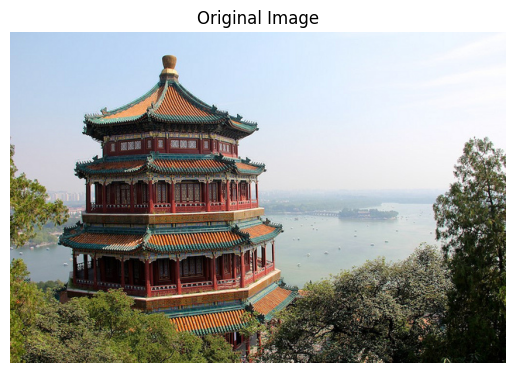

In [36]:
from sklearn.datasets import load_sample_images
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

img = load_sample_images()["images"][0]
print(type(img))
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

numpy.ndarrayのデータをJPEGにエンコード

In [37]:
data = tf.io.encode_jpeg(img)
print(type(data))
print(type(data.numpy()))
# protbufとしてデータを定義
example_with_image = Example(features=Features(feature={
    "image": Feature(bytes_list=BytesList(value=[data.numpy()]))}))
# シリアライゼーション
serialized_example = example_with_image.SerializeToString()
print(type(serialized_example))
# then save to TFRecord

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'bytes'>
<class 'bytes'>


ロード&パース, シリアライズする前の形式に戻っている

In [41]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }
example_with_image = tf.io.parse_single_example(serialized_example, feature_description)
example_with_image

{'image': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x290b524c0>}

デコードはどちらでも良い。`decode_image` はJPEGだけでなく、さまざまな形式に対応可能

In [39]:
#decoded_img = tf.io.decode_jpeg(example_with_image["image"].values[0])
decoded_img = tf.io.decode_image(example_with_image["image"].values[0])
print(type(decoded_img))

<class 'tensorflow.python.framework.ops.EagerTensor'>


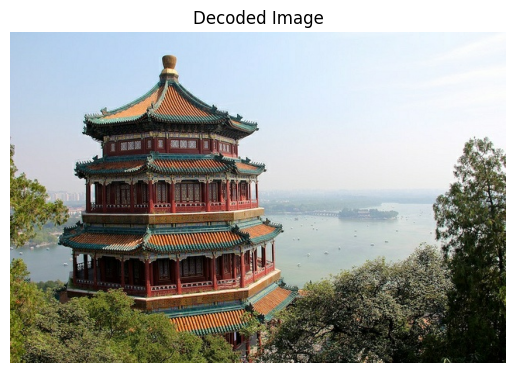

In [42]:
plt.imshow(decoded_img)
plt.title("Decoded Image")
plt.axis("off")
plt.show()

### テンソルをTFRecordsで取り扱う場合 (これも`BytesList`で取り扱い可能)

テンソルを扱う場合

- write
    - `tf.io.serialize_tensor()` でテンソルをシリアライズ
    - その後 `BytesList`に格納可能
- load
    - もとのデータが必要になったら、`tf.io.parse_tensor()`でデータをパース

#### サンプルデータの作成とシリアライゼーション

In [43]:
t = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
s = tf.io.serialize_tensor(t)
s

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

#### ロード、パースは`tf.io.parse_tensor()`を使う

In [44]:
tf.io.parse_tensor(s, out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

### インスタンス毎にパースするのではなく、バッチ毎にパースしたい場合

- `tf.io.parse_single_example`の代わりに`tf.io.parse_example()` を使う

In [45]:
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(10)
for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples,
                                          feature_description)

In [46]:
parsed_examples

{'image': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x160500a00>}